<a href="https://colab.research.google.com/github/rahamath10/face-recognition-app/blob/main/final_face_recognition_app_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q kaggle opencv-python scikit-learn streamlit joblib pyngrok


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 52.8 MB/s eta 0:00:00


In [3]:
from google.colab import files
files.upload()   # upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rahamathsameema","key":"f6380610800086c9ceb29e71bd1ad36e"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d jessicali9530/lfw-dataset


Dataset URL: https://www.kaggle.com/datasets/jessicali9530/lfw-dataset
License(s): other
  0% 0.00/112M [00:00<?, ?B/s]
100% 112M/112M [00:00<00:00, 1.17GB/s]


In [6]:
!unzip -q lfw-dataset.zip


In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

X = []
y = []
label_map = {}
label_id = 0

dataset_path = "lfw-deepfunneled/lfw-deepfunneled"

for person in os.listdir(dataset_path):
    person_path = os.path.join(dataset_path, person)
    if not os.path.isdir(person_path):
        continue

    label_map[label_id] = person

    for img_name in os.listdir(person_path):
        img_path = os.path.join(person_path, img_name)

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        img = cv2.resize(img, (64, 64))
        img = img / 255.0

        X.append(img.flatten())
        y.append(label_id)

    label_id += 1

X = np.array(X)
y = np.array(y)

print("Total images:", X.shape[0])
print("Total people:", len(label_map))


Total images: 13233
Total people: 5749


In [9]:
unique_labels, counts = np.unique(y, return_counts=True)
single_sample_labels = unique_labels[counts == 1]

mask = ~np.isin(y, single_sample_labels)

X = X[mask]
y = y[mask]

print("After filtering:")
print("Images:", X.shape[0])


After filtering:
Images: 9164


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = SVC(kernel='linear', C=1, probability=True)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         0
          23       0.00      0.00      0.00         1
          25       0.50      0.25      0.33         4
          31       0.00      0.00      0.00         1
          34       0.00      0.00      0.00         2
          39       0.00      0.00      0.00         1
          50       0.12      0.17      0.14         6
          51       0.00      0.00      0.00         1
          54       0.00      0.00      0.00         3
          58       0.00      0.00      0.00         0
          59       0.00      0.00      0.00         1
          60       0.00      0.00      0.00         1
          65       0.00      0.00      0.00         4
          67       0.00      0.00      0.00         1
          72       0.00      0.00      0.00         2
          81       0.00    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

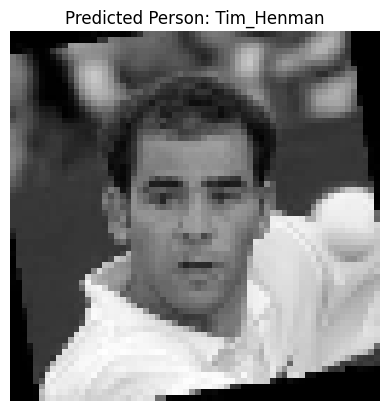

In [11]:
sample = X_test[0].reshape(64, 64)
plt.imshow(sample, cmap="gray")
plt.title(f"Predicted Person: {label_map[y_pred[0]]}")
plt.axis("off")
plt.show()


In [12]:
import joblib

joblib.dump(model, "face_model.pkl")
np.save("label_map.npy", label_map)

print("✅ Model & labels saved")


✅ Model & labels saved


In [13]:
%%writefile app.py
import streamlit as st
import cv2
import numpy as np
import joblib

model = joblib.load("face_model.pkl")
label_map = np.load("label_map.npy", allow_pickle=True).item()

st.set_page_config(page_title="Face Recognition App")

st.title("🧑 Face Recognition Web App")
st.write("Upload a face image to identify the person")

uploaded_file = st.file_uploader(
    "Upload Image",
    type=["jpg", "jpeg", "png"]
)

if uploaded_file:
    file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
    img = cv2.imdecode(file_bytes, cv2.IMREAD_GRAYSCALE)

    if img is not None:
        img = cv2.resize(img, (64, 64))
        img_norm = img / 255.0
        img_flat = img_norm.reshape(1, -1)

        pred = model.predict(img_flat)[0]
        confidence = model.predict_proba(img_flat).max()

        st.image(img, caption="Uploaded Image", width=200)
        st.success(f"Predicted Person: **{label_map[pred]}**")
        st.info(f"Confidence: {confidence:.2f}")


Writing app.py


In [17]:
from pyngrok import ngrok

ngrok.set_auth_token("30VFdZQO8VFlbyWZc0X7hDjzvBS_4HWuYSgsT6QhjFGn9zYMw")

!streamlit run app.py & ngrok http 8501





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.48.173.248:8501

  Stopping...
Traceback (most recent call last):
  File "/usr/local/bin/ngrok", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pyngrok/ngrok.py", line 634, in main
    run(sys.argv[1:])
  File "/usr/local/lib/python3.12/dist-packages/pyngrok/ngrok.py", line 622, in run
    process.run_process(pyngrok_config.ngrok_path, args)
  File "/usr/local/lib/python3.12/dist-packages/pyngrok/process.py", line 312, in run_process
    subprocess.call(start)
  File "/usr/lib/python3.12/subprocess.py", line 391, in call
    return p.wait(timeout=timeout)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/subprocess.py", line 1264, in wait
    return self._wait(timeout=timeout)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/subprocess.py

In [18]:
!streamlit run app.py & ngrok http 8501





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.48.173.248:8501

  Stopping...
Traceback (most recent call last):
  File "/usr/local/bin/ngrok", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pyngrok/ngrok.py", line 634, in main
    run(sys.argv[1:])
  File "/usr/local/lib/python3.12/dist-packages/pyngrok/ngrok.py", line 622, in run
    process.run_process(pyngrok_config.ngrok_path, args)
  File "/usr/local/lib/python3.12/dist-packages/pyngrok/process.py", line 312, in run_process
    subprocess.call(start)
  File "/usr/lib/python3.12/subprocess.py", line 391, in call
    return p.wait(timeout=timeout)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/subprocess.py", line 1264, in wait
    return self._wait(timeout=timeout)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/subprocess.py